In [1]:
import json
import os
import numpy as np
from PIL import Image
import random
import torch

from mvdream.camera_utils import get_camera, create_camera_to_world_matrix, normalize_camera

# Prevent kernel crash
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set static seed
random.seed(0)

EXPERIMENT_NAME = "dinosaur_0_mask_masked_bckg"
EXPERIMENT_PATH = f"../out/{EXPERIMENT_NAME}"
os.makedirs(EXPERIMENT_PATH, exist_ok=True) 


In [2]:
dataset_dir = "..\\..\\dissertation_template\\data\\ScanNeRF"
data_class = "trex\\trex"
data_mode = "transparent_bck"

data_root = os.path.join(os.pardir, dataset_dir, data_class, data_mode)

train_transform_file = os.path.join(data_root, "transforms_train.json")
val_transforms_file = os.path.join(data_root, "transforms_eval.json")


In [3]:
def load_from_json(path):
    with open(path) as f:
        return json.load(f)

def load_dataset(rootdir, split):
    transforms = load_from_json(os.path.join(rootdir, f"transforms_{split}.json"))
        
    # Initialize a list to store the loaded images
    loaded_transforms = []

    # Iterate through the poses
    for frame in transforms["frames"]:
        img_path = os.path.join(data_root, frame["file_path"])
        img_path = img_path.replace("/", "\\") + ".png"
        
        # Open the image using PIL (Pillow)
        img = np.array(Image.open(img_path))
        
        frame["img"] = img
        frame["camera_to_world"] = np.array(frame["transform_matrix"]).astype(np.float32)
        
        # Align input camera poses with unit sphere.
        frame["camera_to_world"] = normalize_camera(frame['camera_to_world']).reshape(4,4)
        
        loaded_transforms.append(frame)
    
    return loaded_transforms
    

In [4]:
train_ds = load_dataset(data_root, "train")
val_ds = load_dataset(data_root, "val")

In [5]:
def getRandomPoses(ds, n=3):
    return random.sample(ds, n)

def crop_center(img, w = 1024, h = 1024):
    # Get the current size of the image
    current_width, current_height = img.size

    # Calculate the coordinates for cropping
    left = (current_width - w) // 2
    top = (current_height - h) // 2
    right = (current_width + w) // 2
    bottom = (current_height + h) // 2

    cropped_image = img.crop((left, top, right, bottom))

    return cropped_image

def sample_pose(ds, poses=None):
    if poses is None:
        poses = getRandomPoses(ds, 4)

    for pose in poses:
        # Crop to get 1x1 aspect ratio
        img = crop_center(Image.fromarray(pose['img']), 1024, 1024)

        # Downscale image to required model input size (256, 256)
        img.thumbnail((256, 256), resample=Image.Resampling.BICUBIC)

        # Ignore alpha channel and convert to numpy array
        np_img = np.array(img)
    
        pose['scaled_img'] = np_img
    
        # Get camera positions
    
    return poses

train_sampled_poses = sample_pose(train_ds, poses=[train_ds[x] for x in range(4)])
val_sampled_poses = sample_pose(val_ds)

In [6]:
# Check if camera matrices match autogenerated ones
azimuth_start = 0
azimuth_span = 360
angle_gap = 30
elevation = 0

azimuths = [azimuth for azimuth in np.arange(azimuth_start, azimuth_span+azimuth_start, angle_gap)]
autogen_sampled_poses = [create_camera_to_world_matrix(elevation, azimuth) for azimuth in azimuths]

In [7]:
# Original Author: https://github.com/demul/extrinsic2pyramid/tree/main
# Visualize camera poses in scene
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class CameraPoseVisualizer:
    def __init__(self, xlim, ylim, zlim):
        self.fig = plt.figure(figsize=(18, 7))
        self.ax = self.fig.add_subplot(projection='3d')
        self.ax.set_aspect("auto")
        self.ax.set_xlim(xlim)
        self.ax.set_ylim(ylim)
        self.ax.set_zlim(zlim)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('z')
        print('initialize camera pose visualizer')

    def extrinsic2pyramid(self, extrinsic, color='r', focal_len_scaled=5, aspect_ratio=0.3):
        vertex_std = np.array([[0, 0, 0, 1],
                               [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
        vertex_transformed = vertex_std @ extrinsic.T
        meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
        self.ax.add_collection3d(
            Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))

    def customize_legend(self, list_label):
        list_handle = []
        for idx, label in enumerate(list_label):
            color = plt.cm.rainbow(idx / len(list_label))
            patch = Patch(color=color, label=label)
            list_handle.append(patch)
        plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5), handles=list_handle)

    def colorbar(self, max_frame_length):
        cmap = mpl.cm.rainbow
        norm = mpl.colors.Normalize(vmin=0, vmax=max_frame_length)
        self.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Frame Number')

    def show(self):
        plt.title('Extrinsic Parameters')
        plt.show()

initialize camera pose visualizer


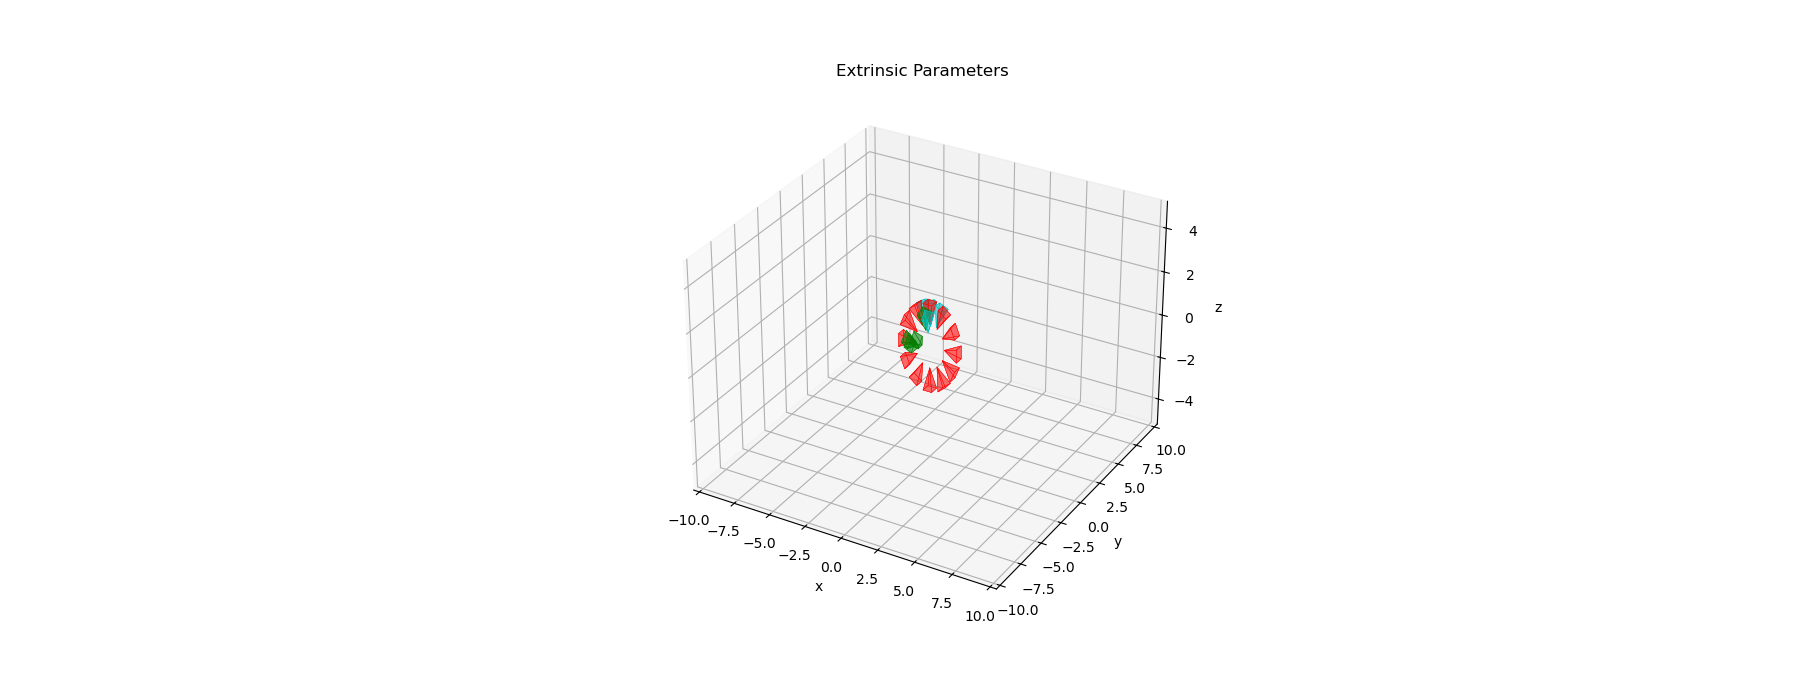

In [8]:
%matplotlib widget

# Visualize sampled camera angles in a 3D scene

visualizer = CameraPoseVisualizer([-10, 10], [-10, 10], [-5, 5])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
for frame in train_sampled_poses:
    pose = frame['camera_to_world']
    visualizer.extrinsic2pyramid(pose, 'c', 1)

for frame in val_sampled_poses:
    pose = frame['camera_to_world']
    visualizer.extrinsic2pyramid(pose, 'g', 1)
    
for pose in autogen_sampled_poses:
    visualizer.extrinsic2pyramid(pose, 'r', 1)

visualizer.show()

In [9]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid



imgs = [Image.fromarray(pose['scaled_img']) for pose in train_sampled_poses]

grid = image_grid(imgs, 2, 2)
grid.save(f"{EXPERIMENT_PATH}/og_imgs.png")

In [10]:
from torchvision import transforms as tfms

# Prepare images to be converted to latent space
def prep_x0_img(poses):
    imgs = []
    
    for pose in poses:
        # Ignore alpha channel
        img = Image.fromarray(pose['scaled_img'][:, :, :3])

        init_image = tfms.ToTensor()(img)
        imgs.append(init_image)
    
    x0_img = torch.stack(imgs, dim=0)
    
    return x0_img

x0_img = prep_x0_img(train_sampled_poses)

print(f"Transposed input shape: {x0_img.shape}")

Transposed input shape: torch.Size([4, 3, 256, 256])


In [11]:
class Args():
    model_name='sd-v2.1-base-4view'
    config_path=None
    ckpt_path=None
    text='a toy dinosaur trex'
    suffix=', 3d asset'
    size=256
    num_frames=4
    use_camera=1
    camera_elev=15
    camera_azim=90
    camera_azim_span=360
    seed=23
    fp16=False
    device='cuda'

In [12]:
import argparse
from mvdream.model_zoo import build_model
from omegaconf import OmegaConf
from mvdream.ldm.util import instantiate_from_config
from mvdream.ldm.models.diffusion.ddim import DDIMSampler

parser = argparse.ArgumentParser()
parser.add_argument("--model_name", type=str, default="sd-v2.1-base-4view", help="load pre-trained model from hugginface")
parser.add_argument("--config_path", type=str, default=None, help="load model from local config (override model_name)")
parser.add_argument("--ckpt_path", type=str, default=None, help="path to local checkpoint")
parser.add_argument("--text", type=str, default="a toy dinosaur trex")#"an astronaut riding a horse")
parser.add_argument("--suffix", type=str, default=", 3d asset")
parser.add_argument("--size", type=int, default=256)
parser.add_argument("--num_frames", type=int, default=4, help="num of frames (views) to generate")
parser.add_argument("--use_camera", type=int, default=1)
parser.add_argument("--camera_elev", type=int, default=15)
parser.add_argument("--camera_azim", type=int, default=90)
parser.add_argument("--camera_azim_span", type=int, default=360)
parser.add_argument("--seed", type=int, default=23)
parser.add_argument("--fp16", action="store_true")
parser.add_argument("--device", type=str, default='cuda')
#args = parser.parse_args()
args = Args()

dtype = torch.float32 if args.fp16 else torch.float16
device = args.device
batch_size = max(4, args.num_frames)

print("load t2i model ... ")
if args.config_path is None:
    model = build_model(args.model_name, ckpt_path=args.ckpt_path)
else:
    assert args.ckpt_path is not None, "ckpt_path must be specified!"
    config = OmegaConf.load(args.config_path)
    model = instantiate_from_config(config.model)
    model.load_state_dict(torch.load(args.ckpt_path, map_location='cpu'))
model.device = device
model.to(device)
model.eval()

sampler = DDIMSampler(model)
uc = model.get_learned_conditioning( [""] ).to(device)
print("load t2i model done . ")

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


load t2i model ... 
Loading model from config: sd-v2-base.yaml
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 20 heads.
Setting up MemoryEfficientCrossAttention

In [13]:
import gc
torch.cuda.empty_cache()
gc.collect()

#Image.fromarray(list(255. * x0_img.permute(0,2,3,1).cpu().numpy().astype(np.uint8)))
#og_np_img = np.concatenate(x0_img.permute(0,2,3,1).cpu().numpy().astype(np.uint8), 1)
#og_np_img.shape

#Image.fromarray(og_np_img).save(f"../out/og_train.png")

15

In [205]:
def x0_img_to_latents(init_image):
    '''     
    Function to convert rescaled and reshaped x0_img to latents     
    '''
    # Regularize image for VAE encoding
    init_image = init_image * 2.0 - 1.0

    init_image = init_image.to(device="cuda", dtype=torch.float32)
    print(f"init_image shape: {init_image.size()}")
    # Encode with default scaling param
    init_latent_dist = model.first_stage_model.encode(init_image).sample() * 0.18215   
    return init_latent_dist

def x0_latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():
        image = model.first_stage_model.decode(latents)#.sample #vae.decode(latents).sample
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")     
    pil_images = [Image.fromarray(image) for image in images]        
    return pil_images

def x0_latents_to_np(latents):
    '''
    Function to convert latents to images
    '''     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():
        image = model.first_stage_model.decode(latents)#.sample #vae.decode(latents).sample
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")       
    return images

In [15]:
# Encode 
with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    latent_img = x0_img_to_latents(x0_img)
print(f"Dimension of this original representation: {x0_img.shape}")
print(f"Dimension of this latent representation: {latent_img.shape}")

init_image shape: torch.Size([4, 3, 256, 256])
Dimension of this original representation: torch.Size([4, 3, 256, 256])
Dimension of this latent representation: torch.Size([4, 4, 32, 32])


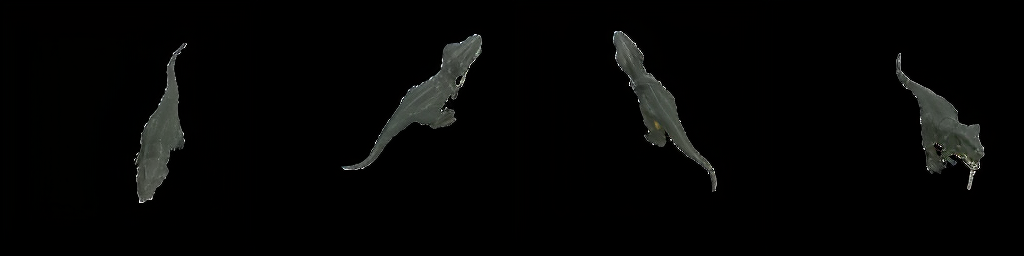

In [16]:
with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    decoded_img = x0_latents_to_pil(latent_img)
    decoded_img[0]

decoded_img = np.concatenate(decoded_img, 1)
encodeDecode = Image.fromarray(decoded_img)
encodeDecode.save(f"{EXPERIMENT_PATH}/EncodeDecode.png")

encodeDecode

In [17]:
# For comparison, test out the originad unfinetuned VAE encoder
## To import an image from a URL 
from fastdownload import FastDownload  

import torch, logging
## Imaging  library 
from PIL import Image 
## Basic libraries 
import numpy as np 
import matplotlib.pyplot as plt 

## Loading a VAE model 
from diffusers import AutoencoderKL 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float32).to("cuda")
def load_image(p):    
    return Image.open(p).convert('RGB').resize((256,256))
def pil_to_latents(image):
    '''     
    Function to convert image to latents     
    '''     
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    print(f"Transformed image shape: {init_image.shape}")
    init_image = init_image.to(device="cuda", dtype=torch.float32)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215     
    return init_latent_dist  
def latents_to_pil(latents):     
    ''' 
    Function to convert latents to images     
    '''     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():         
        image =  vae.decode(latents).sample     
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")     
    pil_images = [Image.fromarray(image) for image in images]        
    return pil_images

def x0_img_to_latents_og_model(init_image):
    '''     
    Function to convert rescaled and reshaped x0_img to latents     
    '''
    # Regularize image for VAE encoding
    init_image = init_image * 2.0 - 1.0

    init_image = init_image.to(device="cuda", dtype=torch.float32)

    # Encode with default scaling param
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215   
    return init_latent_dist

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [18]:
import gc

torch.cuda.empty_cache()
gc.collect()
# Encode with original encoder
with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    latent_img_base = x0_img_to_latents_og_model(x0_img)
print(f"Dimension of this original representation: {x0_img.shape}")
print(f"Dimension of this latent representation: {latent_img.shape}")

Dimension of this original representation: torch.Size([4, 3, 256, 256])
Dimension of this latent representation: torch.Size([4, 4, 32, 32])


In [19]:
torch.cuda.empty_cache()
gc.collect()

p = FastDownload().download('https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg')
img = load_image(p)
print(f"Dimension of this image: {np.array(img).shape}")
img = crop_center(Image.fromarray(train_ds[0]['img'][:,:,:3]))
img.thumbnail((256, 256))


z = tfms.ToTensor()(img).unsqueeze(0) * 2.0 - 1.0
print(z.size())

z_x0 = torch.from_numpy((np.stack([img], axis=0)).transpose(0, 3, 1, 2) * 2.0 - 1.0)
print(z_x0.shape)

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    init_image_a = z.to(device="cuda", dtype=torch.float32)
    init_latent_dist = model.first_stage_model.encode(init_image_a).sample() * 0.18215   

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    init_image_b = z_x0.to(device="cuda", dtype=torch.float32)
    init_latent_dist_x0 = vae.encode(init_image_b).latent_dist.sample() * 0.18215

# tfms.ToTensor()(img) != torch.from_numpy???
init_image_a - init_image_b

Dimension of this image: (256, 256, 3)
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

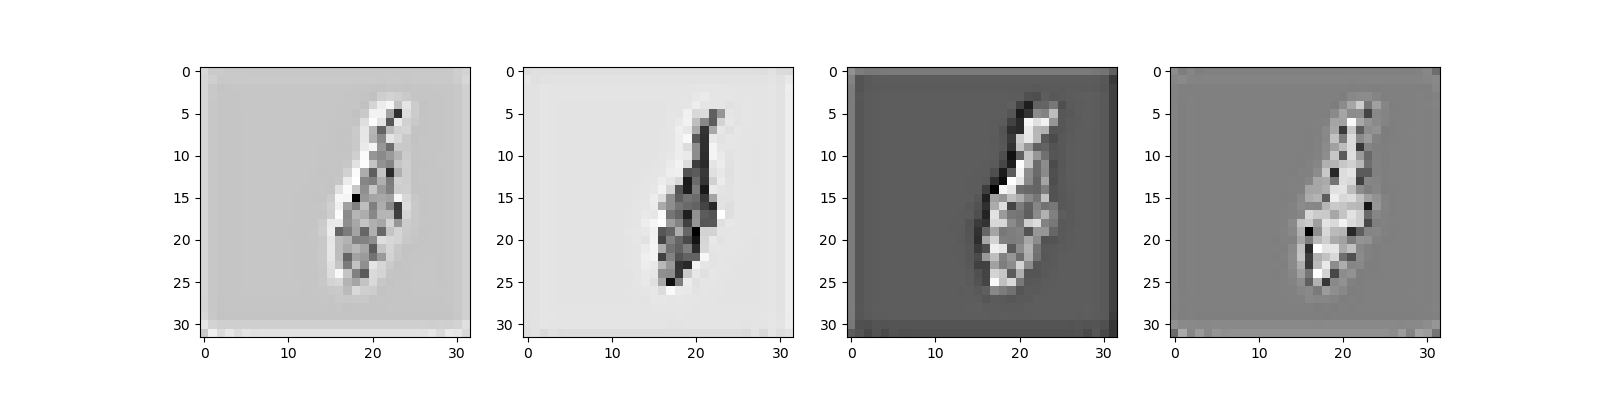

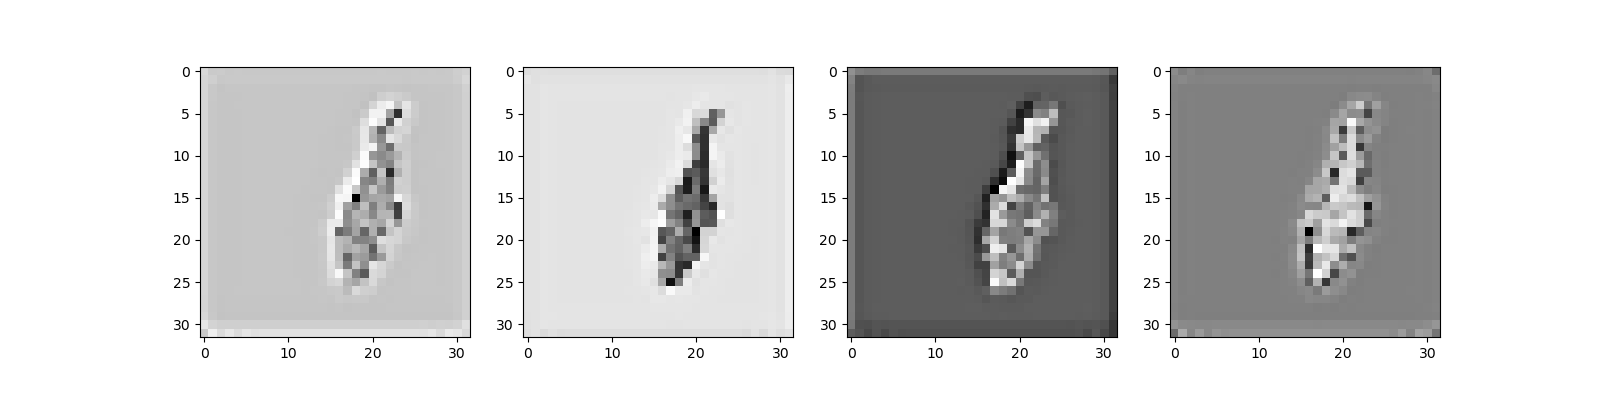

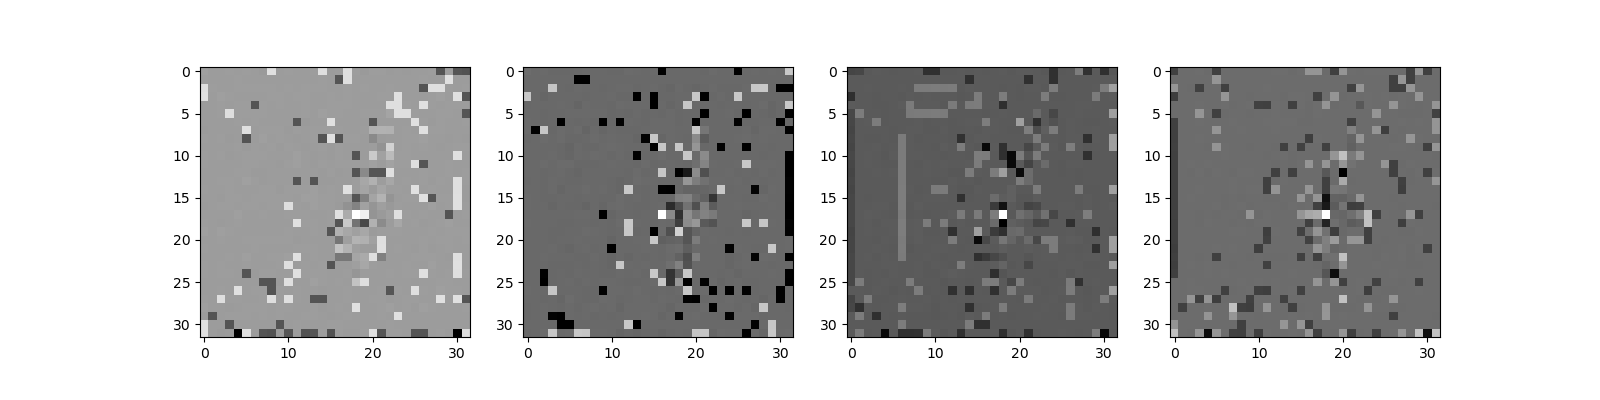

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img_base[0][c].detach().cpu(), cmap='Greys')

fig.savefig(f"{EXPERIMENT_PATH}/LatentBase.png")

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu(), cmap='Greys')

fig.savefig(f"{EXPERIMENT_PATH}/Latent.png")

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu() - latent_img_base[0][c].detach().cpu(), cmap='Greys')

fig.savefig(f"{EXPERIMENT_PATH}/LatentDiff.png")

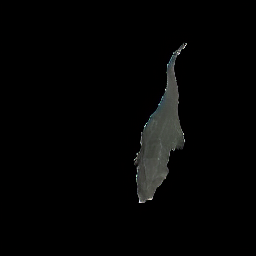

In [21]:
import gc
torch.cuda.empty_cache()
gc.collect()


latent_img[:2,:,:,:].reshape(2, 4, 32, 32).shape
decoded_img = latents_to_pil(latent_img_base[0,:,:,:].reshape(-1, 4, 32, 32))

decoded_img[0]

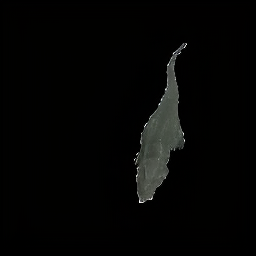

In [22]:
torch.cuda.empty_cache()
gc.collect()

decoded_img = x0_latents_to_pil(latent_img_base[0,:,:,:].reshape(-1, 4, 32, 32))

decoded_img[0]


In [23]:
import torch
from PIL import Image
import open_clip

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
#tokenizer = open_clip.get_tokenizer('ViT-B-32')

#image = preprocess(Image.open("CLIP.png")).unsqueeze(0)
#text = tokenizer(["a diagram", "a dog", "a cat"])

#with torch.no_grad(), torch.cuda.amp.autocast():
#    image_features = model.encode_image(image)
#    text_features = model.encode_text(text)
#    image_features /= image_features.norm(dim=-1, keepdim=True)
#    text_features /= text_features.norm(dim=-1, keepdim=True)

#    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

#print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

In [186]:
def ti2i(model, image_size, prompt, uc, sampler, step=20, scale=7.5, batch_size=8, ddim_eta=0., dtype=torch.float32, device="cuda", camera=None, num_frames=1, x0=None, mask=None, temperature=1., noise_dropout=0., quantize_x0=False, verbose=False, img_callback=None, evaluate_inter=False, decode_inter=False):
    with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
        if type(prompt) == Image.Image:
            c = model.cond_stage_model.preprocess(prompt).unsqueeze(0)
            c = clip_model.encode_image(c).to(device)
            c /= c.norm(dim=-1, keepdim=True)
        else:
            if type(prompt)!=list:
                prompt = [prompt]
            c = model.get_learned_conditioning(prompt).to(device)
            
        c_ = {"context": c.repeat(batch_size,1,1)}
        uc_ = {"context": uc.repeat(batch_size,1,1)}
        if camera is not None:
            c_["camera"] = uc_["camera"] = camera
            c_["num_frames"] = uc_["num_frames"] = num_frames

        eval_callback = None
        if evaluate_inter:
            eval_callback =  img_callback

        # 4 channels of size 32x32, batch_size = 4 (4 frames per batch)
        shape = [4, image_size // 8, image_size // 8]
        samples_ddim, intermediaries = sampler.sample(S=step, conditioning=c_,
                                        batch_size=batch_size, shape=shape,
                                        verbose=verbose,
                                        log_every_t=2, 
                                        unconditional_guidance_scale=scale,
                                        unconditional_conditioning=uc_,
                                        temperature=temperature, noise_dropout=noise_dropout,
                                        quantize_x0=quantize_x0,
                                        eta=ddim_eta, x_T=None, x0=x0, mask=mask,
                                        img_callback = eval_callback)

        if img_callback:
            img_callback(samples_ddim, -1)

        decoded_intermediaries = []

        if decode_inter:  
            for inter_samples_ddim in intermediaries["x_inter"]:
                # Decode (upscale) the images
                x_sample = model.decode_first_stage(inter_samples_ddim) 
                x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
                x_sample = 255. * x_sample.permute(0,2,3,1).cpu().numpy()
                decoded_intermediaries.append(list(x_sample.astype(np.uint8)))

        x_sample = model.decode_first_stage(samples_ddim)
        x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
        x_sample = 255. * x_sample.permute(0,2,3,1).cpu().numpy()
        
    return (list(x_sample.astype(np.uint8)), decoded_intermediaries)

In [176]:
def get_camera_param(poses):
    cameras = []
    for pose in poses:
        camera_matrix = pose['camera_to_world']
        cameras.append(camera_matrix.flatten())
    return torch.tensor(np.stack(cameras, 0)).float()

initialize camera pose visualizer


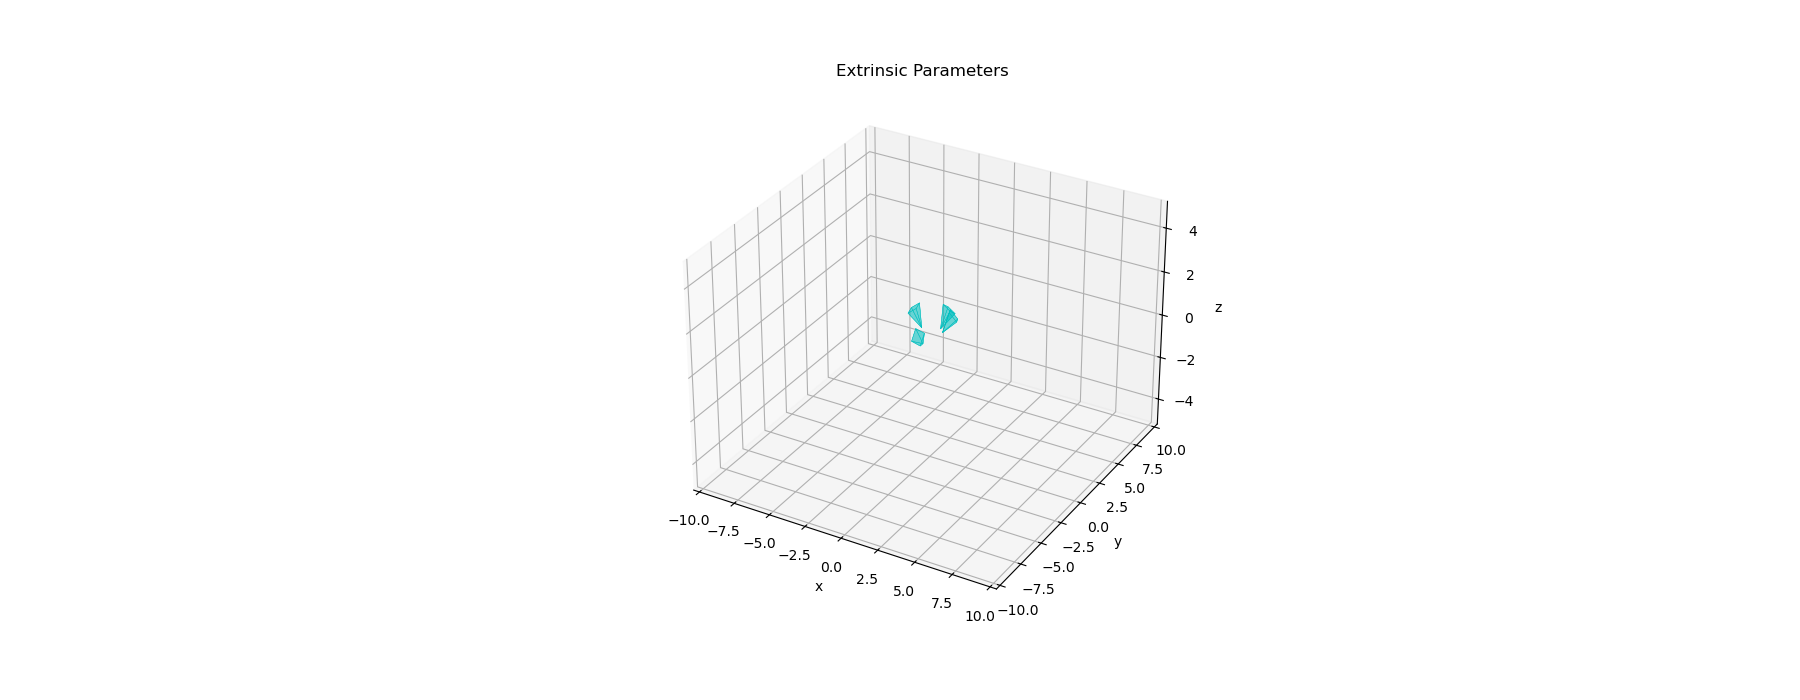

init_image shape: torch.Size([4, 3, 256, 256])


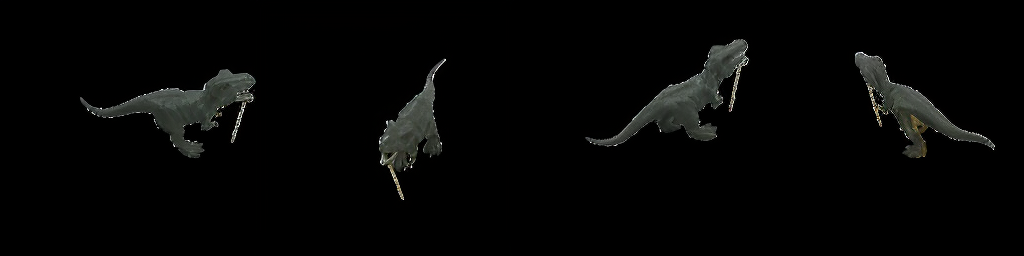

In [227]:
train_sampled_poses = sample_pose(train_ds, poses=[train_ds[5], train_ds[6], train_ds[4], train_ds[8]])
x0_img = prep_x0_img(train_sampled_poses)

visualizer = CameraPoseVisualizer([-10, 10], [-10, 10], [-5, 5])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
for frame in train_sampled_poses:
    pose = frame['camera_to_world']
    visualizer.extrinsic2pyramid(pose, 'c', 1)

#for frame in train_ds:
#    pose = frame['camera_to_world']
#    visualizer.extrinsic2pyramid(pose, 'r', 1)

visualizer.show()

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    latent_img = x0_img_to_latents(x0_img)

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    sim_decoded = x0_latents_to_np(latent_img.clone())
    decoded_img = x0_latents_to_pil(latent_img)
    decoded_img[0]

calc_sim_to = np.array(sim_decoded)

decoded_img = np.concatenate(decoded_img, 1)
encodeDecode = Image.fromarray(decoded_img)
encodeDecode
#encodeDecode.save(f"{EXPERIMENT_PATH}/EncodeDecode.png")

In [243]:
batch_size = max(4, args.num_frames)

# Get the camera conditioning from training images
camera = get_camera_param(train_sampled_poses)
camera = camera.repeat(batch_size//args.num_frames, 1).to(device)

# Get textual encoding
args.text = "Toy T-rex"
t = args.text# + args.suffix

# Get image encoding
#t = Image.fromarray(train_sampled_poses[1]['img'][:,:,:3])

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    latent_img = x0_img_to_latents(x0_img)

# Set mask
mask = torch.ones(latent_img.shape, device=device)
mask[0, :, :, :] = 0
#mask[1, :, :, :] = 0
#mask[2, :, :, :] = 0
#mask[3, :, :, :] = 0

calc_latent_sim_to = latent_img.clone()
#print(calc_sim_to)
# Randomize input image
latent_img[0] = torch.randn(latent_img.shape[1:], device=device)
#latent_img[1] = torch.randn(latent_img.shape[1:], device=device)
#latent_img[2] = torch.randn(latent_img.shape[1:], device=device)
#latent_img[3] = torch.randn(latent_img.shape[1:], device=device)

init_image shape: torch.Size([4, 3, 256, 256])


In [244]:
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio, LearnedPerceptualImagePatchSimilarity

ssim = StructuralSimilarityIndexMeasure().to(device)
psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
lpips = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)

def calc_latent_image_metrics(pred_x0, i):
    target = calc_latent_sim_to
    
    ssim_metric = ssim(target, pred_x0)
    psnr_metric = psnr(target, pred_x0)
    #lpips_metric = lpips(target, pred_x0)
    print(f"{i} - ssim: {ssim_metric} psnr: {psnr_metric}") #lpips: {lpips_metric}")

def calc_rgb_image_metrics(pred_x0, i):
    target = calc_sim_to
    
    target = target.transpose(0, 3, 1, 2)
    pred_x0 = pred_x0.transpose(0, 3, 1, 2)
    #ssim_metric = ssim(target, pred_x0)
   # psnr_metric = psnr(target, pred_x0)
    lpips_metric = lpips(target, pred_x0)

    print(f"{i} - lpips: {lpips_metric}")

DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.81it/s]


-1 - ssim: 0.7771705389022827 psnr: 2.450096845626831


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.62it/s]


-1 - ssim: 0.8192849159240723 psnr: 8.6402006149292


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.55it/s]


-1 - ssim: 0.8271554112434387 psnr: 10.241931915283203


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.62it/s]


-1 - ssim: 0.8324073553085327 psnr: 10.66538143157959


DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.57it/s]


-1 - ssim: 0.8335927724838257 psnr: 10.344110488891602


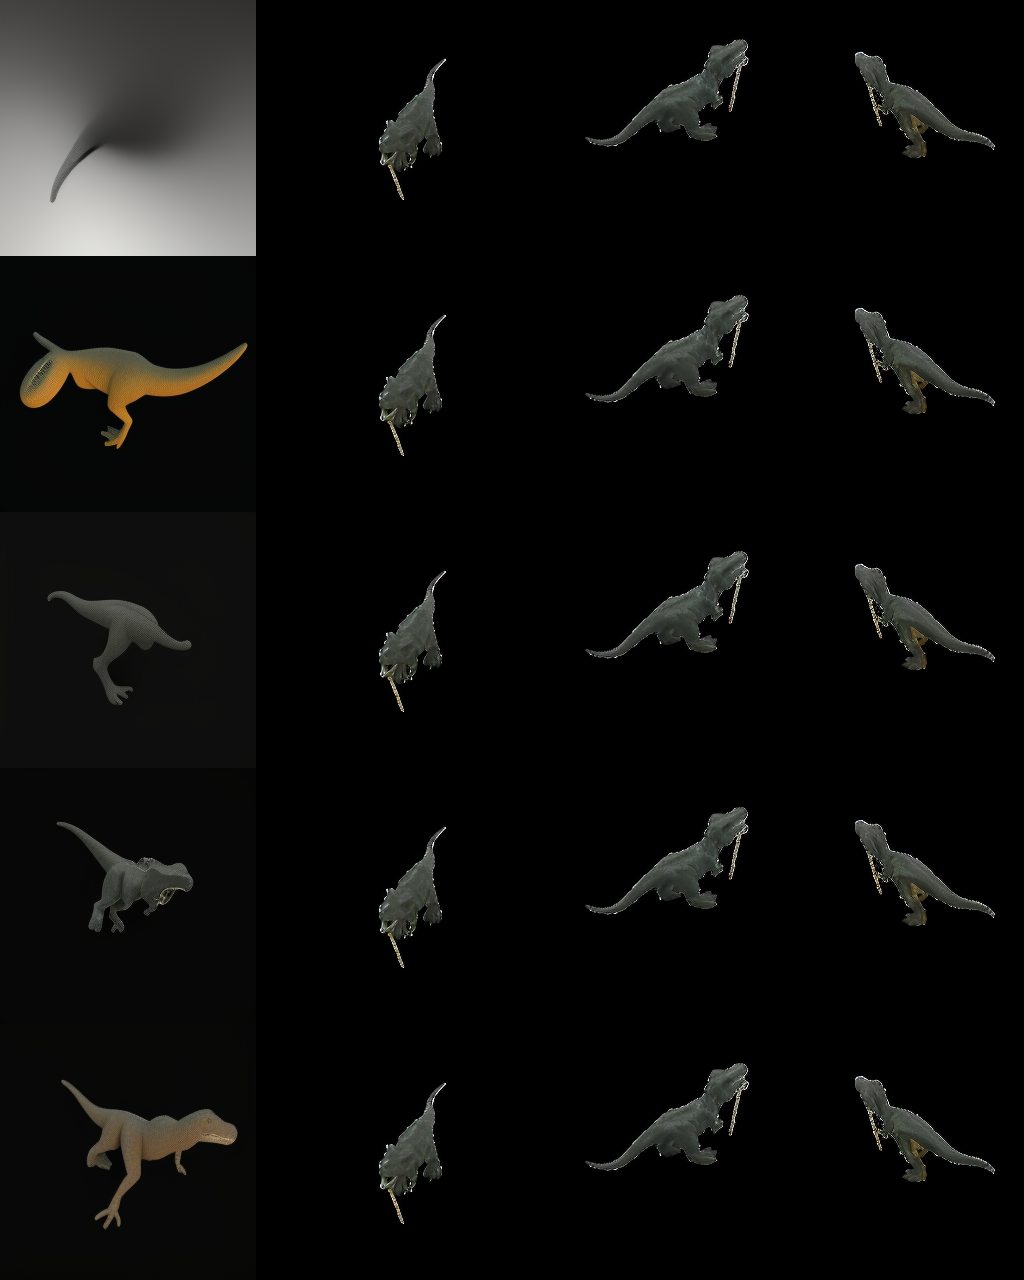

In [246]:
images = []

for j in range(5):
    img, inter_images = ti2i(model, args.size, t, uc, sampler, step=50, scale=5, batch_size=batch_size, ddim_eta=0.5, dtype=dtype, device=device, camera=camera, num_frames=args.num_frames, x0=latent_img, mask=mask, temperature=0.01, noise_dropout=0.0, img_callback=calc_latent_image_metrics, evaluate_inter=False)
    # Better is: Low temperature, low scale, high ddim_eta. noise dropout inconsistent? 
    # lower temperature requires higher scale 0.0001
    #calc_rgb_image_metrics(np.array(img), -1)
    img = np.concatenate(img, 1)
    images.append(img)

for idx, inter_img in enumerate(inter_images):
    inter_images = np.concatenate(inter_img, 1)
    Image.fromarray(inter_images).save(f"{EXPERIMENT_PATH}/Dinosaur_inter_{idx}.png")


images = np.concatenate(images, 0)

Image.fromarray(images).save(f"{EXPERIMENT_PATH}/Final_reconstruction.png")
Image.fromarray(images)

In [102]:
import torch
from mvdream.camera_utils import get_camera
model.eval()
model.cuda()
with torch.no_grad():
    noise = torch.randn(4,4,32,32, device="cuda") # batch of 4x for 4 views, latent size 32=256/8
    t = torch.tensor([999]*4, dtype=torch.long, device="cuda") # same timestep for 4 views
    cond = {
        "context": model.get_learned_conditioning([""]*4).cuda(), # text embeddings
        "camera": get_camera(4).cuda(),
        "num_frames": 4,
    }
    eps = model.apply_model(noise, t, cond=cond)

tensor(0.6459)